In [53]:
import otter

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [54]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'theme': 'serif',
        'width': '100%',
        'height': '100%',
        'scroll': True,
})

{'width': '100%',
 'height': '100%',
 'scroll': True,
 'theme': 'serif',
 'transition': 'none'}

# ICCT Interview Presentation

## Predicting Housing Prices in Cook County, Illinois

### Xiaomeng (Lucy) Xu

# Part 0: Background

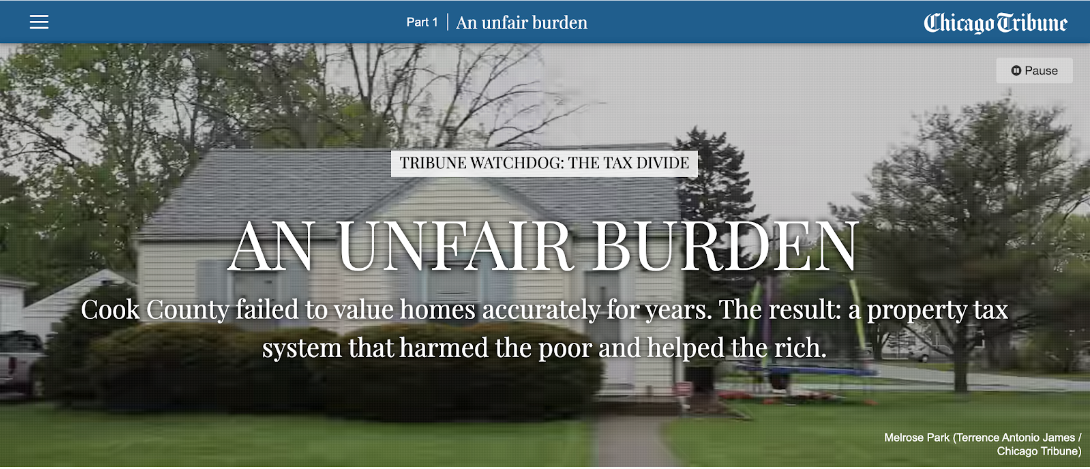

### Problem

- Cook County Assessor's Office (CCAO)

- A model that was inaccurately predicting the value of a home relative to its sales price

- Regressive Tax

- Uneven tax burden on owners of lower-sale priced homes

The Chicago Tribune found out that :

• Cook County Assessor's Office (CCAO)

• A model that was inaccurately predicting the value of a home relative to its sales price

(overvalues inexpensive properties and undervalues expensive properties)
(people living in poorer areas tended to pay more in taxes as a percentage of their home’s value than residents in more wealthier communities)

• Regressive Tax

• Uneven tax burden on owners of lower-sale priced homes
(unfair)

model: depend upon unverified "hand-checks" or manual adjustments of the model


1. Residents in working-class neighborhoods were more likely to receive property tax bills that assumed their homes were worth more than their true market value.
2. Many living in the county’s wealthier and mostly white communities caught a break because property taxes weren’t based on the full value of their homes.

As a result, people living in poorer areas tended to pay more in taxes as a percentage of their home’s value than residents in more affluent communities.

Known as the effective tax rate, the percentage should be roughly the same for everyone living in a single taxing district.
But the Tribune’s analysis shows the rates became skewed in favor of wealthier residents.



The Cook County Assessor's Office (CCAO) relied on a model that was inaccurately predicting the value of a home relative to its sales price, depended upon unverified "hand-checks" or manual adjustments of the model, and supported a system that resulted in higher-property valuations for lower-sale price homes and lower-property valuations for higher-sale price homes, creating an uneven tax burden that disproportionately fell on owners of lower-sale priced homes.

### Goal

- Create a model to predict the sales prices of the home more accurately and applied consistently to all properties


- Contribute to equally distributed tax burden and a more fair system in Cook County


- Expected model performance:

     Training Error (RMSE) < 200K
     
     Test Error (RMSE) < 240K

### Deliverable

In [55]:
from sklearn.preprocessing import OneHotEncoder

def select_columns(data, *columns):
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    return data.loc[(data[variable] > lower) & (data[variable] <= upper), :]

def add_total_bedrooms(data):
    with_rooms = data.copy()
    pattern = r'(\d+) of which are bedrooms'
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pattern).fillna(0).astype(int)
    return with_rooms

def log_transform_1(data,col):
    data['Log ' + col] = np.log(data[col]+1)
    return data

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def substitute_fireplaces(data):
    data = data.copy()
    data['Fireplaces'].replace({0.0:'no_flues',1.0:'one_flues',2.0:'two_flues'},inplace = True)
    return data

def ohe_fireplaces(data):
    copy = data.copy()
    X = data[['Fireplaces']]
    enc = OneHotEncoder(handle_unknown='ignore')
    trans = enc.fit(X).transform(X).toarray()
    name_lst = enc.get_feature_names()
    copy[name_lst] = trans
    return copy

In [56]:
def process_data_fm(data,is_test_set = False):
 
        
    # Add in Bedrooms    
    data = add_total_bedrooms(data)
    
    
    # Apply One-hot Encoding
    data = substitute_fireplaces(data)
    data = ohe_fireplaces(data)
    ohe_columns = data.filter(regex = '^x0_').columns.tolist()
    

    if not is_test_set:
        
        data = remove_outliers(data,
                               variable = 'Sale Price',
                               lower = 50000,
                               upper = 1000000)
        
        # Log Transform
        (data
             .pipe(log_transform, 'Sale Price')
             .pipe(log_transform, 'Building Square Feet')
             .pipe(log_transform_1, 'Estimate (Building)')
             .pipe(log_transform_1, 'Land Square Feet')
             .pipe(log_transform_1, 'Estimate (Land)')
             .pipe(log_transform_1, 'Lot Size')
        )
        
    
    
    # Transform Data, Select Features
    if not is_test_set:
        ohe_columns.append('Log Sale Price')
        data = select_columns(data,
                             'Log Building Square Feet',
                              'Log Land Square Feet',
                              'Log Estimate (Building)',
                              'Log Estimate (Land)',
                              'Log Lot Size',
                              'Bedrooms',
                              *ohe_columns
                             )
    
    # Return predictors and response variables separately
    if is_test_set:
        X = data.fillna(0)
        X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0) + 0.00001)
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        X = X.fillna(0)
        X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0) + 0.00001)
        return X, y

training_data = pd.read_csv('cook_county_train.csv')
processed_data = process_data_fm(training_data)
processed_data

(        Log Building Square Feet  Log Land Square Feet  \
 1                      -0.966557             -0.922566   
 3                      -0.560341             -0.667111   
 6                       0.409117              0.926662   
 7                       2.432797              0.750167   
 8                       0.851779             -1.269119   
 ...                          ...                   ...   
 204786                 -0.856822              0.779394   
 204788                  0.770073              1.653855   
 204789                 -1.188060             -0.908752   
 204790                 -0.499686              0.064632   
 204791                 -0.861598             -1.644985   
 
         Log Estimate (Building)  Log Estimate (Land)  Log Lot Size  Bedrooms  \
 1                      0.094943             0.293182     -0.922566 -0.260162   
 3                      0.172346            -0.641655     -0.667111 -0.260162   
 6                     -0.752715            -0.

In [57]:
from sklearn import linear_model as lm
run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, 200000, 'cook_county_train.csv', None, False, True)

Your RMSE loss is: 121972.20570026986


121972.20570026986

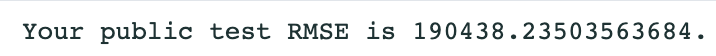

## Part 1. Data Preparation
The data set consists of over 500 thousand records from Cook County, Illinois, and it has 61 features in total; the 62nd is sales price.

In [58]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [59]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [60]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# 68264 observations and 61 features in test data
assert test_data.shape == (68264, 61)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

take a look at the columns in training data, details in codebook

In [61]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

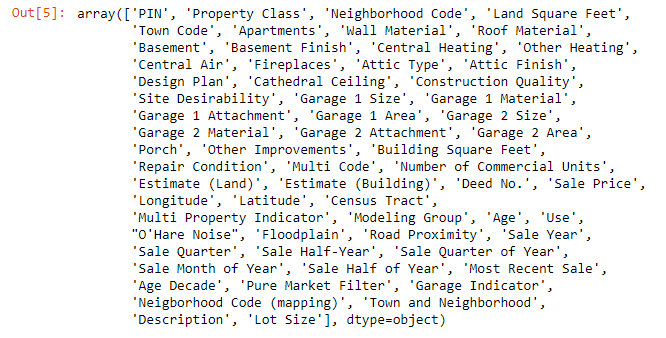

In [62]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

Granularity of the data set: Each row represents one sale of a house in Cook County.

perform eda on the training data

## Part 2. Data Cleaning

In [63]:
training_data = training_data.fillna('')

In [64]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] > lower) & (data[variable] <= upper), :]

## Part 3. Target Variable

In [65]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')

Distribution of `Sale Price`

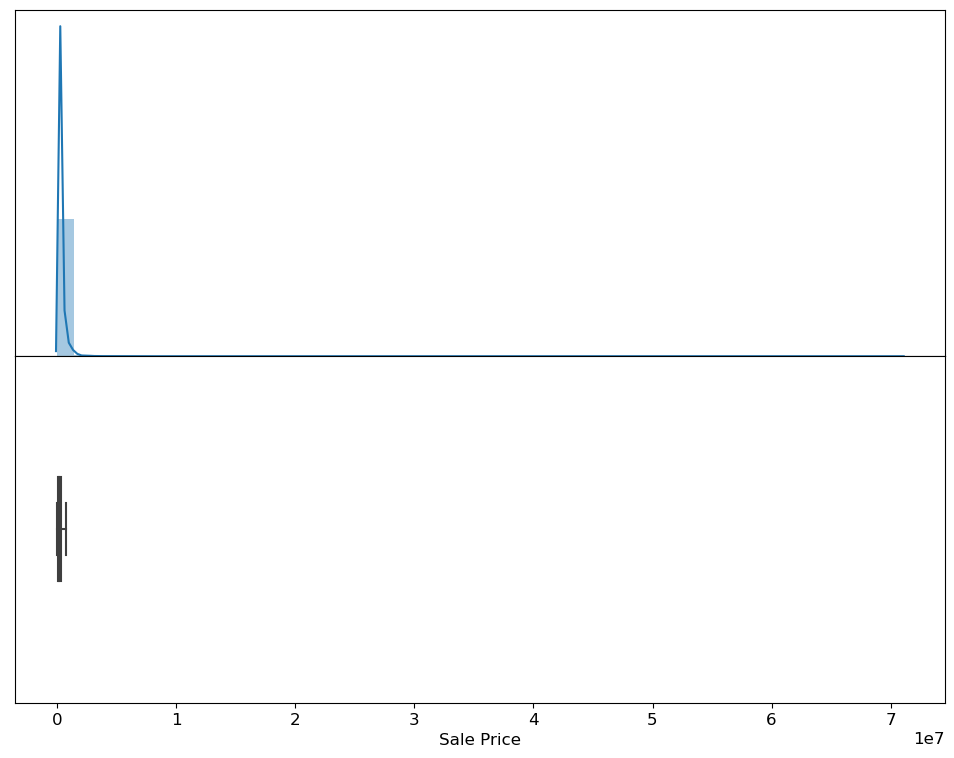

In [66]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

Observation: Extreme outliners to the right end of the distribution, which overly stretches the range of the plot, making the majority of the data nearly impossible to visualize. To reduce the range, the outliers should be removed from the data.

### Reduce the Range

1. Apply log transformation on the `Sale Price`
2. Filter the `Sale Price` and keep the households whose price is at least $500.

Distribution of `Log Sale Price` 
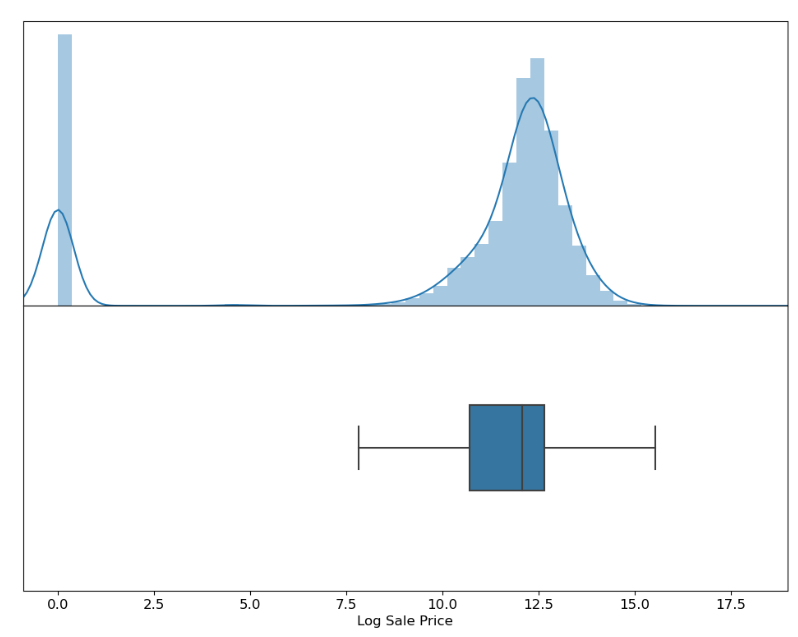

Distribution of `Log Sale Price` with `Sale Price` ≥ 500
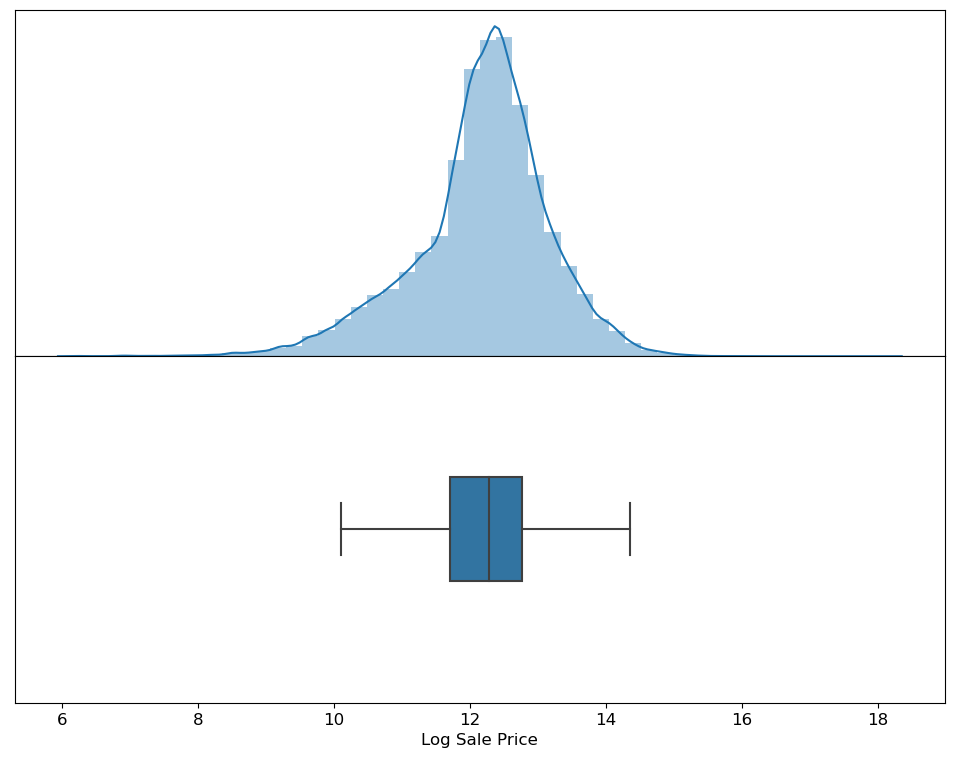

transformation: get linearity

linear regression: feature(parameters)+intercept

Observe: 

1. The distribution of Log Sale Price in the training set is symmetric.
2. At least 25% of the houses in the training set sold for more than $200,000.00.

## Part 4. Modeling
Goal: Predict Housing Price -> Predict `Sale Price` -> Predict `Log Sale Price`

### Step 1: Choose a Model
Linear Regression Model

In [67]:
from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)

### Step 2: Choose a Loss Function
Root Mean Square Error (RMSE)

In [68]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

### Step 3: Fit the Model
Choose the best parameters of the model that minimize the average loss.


### 1. Feature Selection
Which features are relevant to the housing sale price?

- Correlation with `Log Sale Price`

- Intuitive Thinking

- Research

In [69]:
data = pd.read_csv("cook_county_train.csv")
data['Log Sale Price'] = np.log(data['Sale Price'])

abs(data.corr()['Log Sale Price']).sort_values(ascending = False).head(20)

Log Sale Price                1.000000
Pure Market Filter            0.970109
Sale Price                    0.426108
Sale Year                     0.263550
Sale Quarter                  0.260329
Sale Half-Year                0.260207
Deed No.                      0.254731
Town Code                     0.193167
Town and Neighborhood         0.166727
Longitude                     0.162980
PIN                           0.143781
Latitude                      0.131898
Age Decade                    0.131477
Age                           0.131477
Neigborhood Code (mapping)    0.123243
Neighborhood Code             0.123243
Building Square Feet          0.121902
Estimate (Building)           0.118100
Fireplaces                    0.118047
Central Air                   0.112156
Name: Log Sale Price, dtype: float64

Try on: `Age`, `Building Square Feet`, `Estimate (Building)`
- Split train and test set
- Process data
- Fit model
- Predict value
- Model performance

In [70]:
np.random.seed(1337)

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    train_indices = shuffled_indices[:int(data_len*0.8)]
    test_indices = shuffled_indices[int(data_len*0.8):]
    
    train_data = data.iloc[train_indices]
    test_data = data.iloc[test_indices]
    
    return (train_data, test_data)
    
train, test = train_test_split(training_data)

In [71]:
# from feature_func import *    # imports functions from Project 1A
# # run this cell to define process_data_gm and select_columns

def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

X, y design matrix

In [72]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def select_columns(data, *columns):
    return data.loc[:, columns]

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, test_m1 = train_test_split(full_data)

m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (select_columns, ['Log Sale Price', 'Building Square Feet','Estimate (Building)'], None)
]

X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_test_m1, y_test_m1 = process_data_gm(test_m1, m1_pipelines, 'Log Sale Price')


In [73]:
from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)

# Compute the fitted and predicted values of Log Sale Price for 1st model
linear_model_m1.fit(X_train_m1,y_train_m1)
y_fitted_m1 = linear_model_m1.predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_test_m1)

In [74]:
training_error_m1 = rmse(y_fitted_m1,y_train_m1)
test_error_m1 = rmse(y_predicted_m1,y_test_m1)

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1),np.exp(y_train_m1))
test_error_m1_delog = rmse(np.exp(y_predicted_m1),np.exp(y_test_m1))

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))


1st Model
Training RMSE: 0.7551541396334122
Test RMSE: 0.7653184289017014

1st Model (no log transform)
Training RMSE: 694340394046.1887
Test RMSE: 89647964180.03558



### 2.Feature Engineering

### Log Transformation

`Building Square Feet`

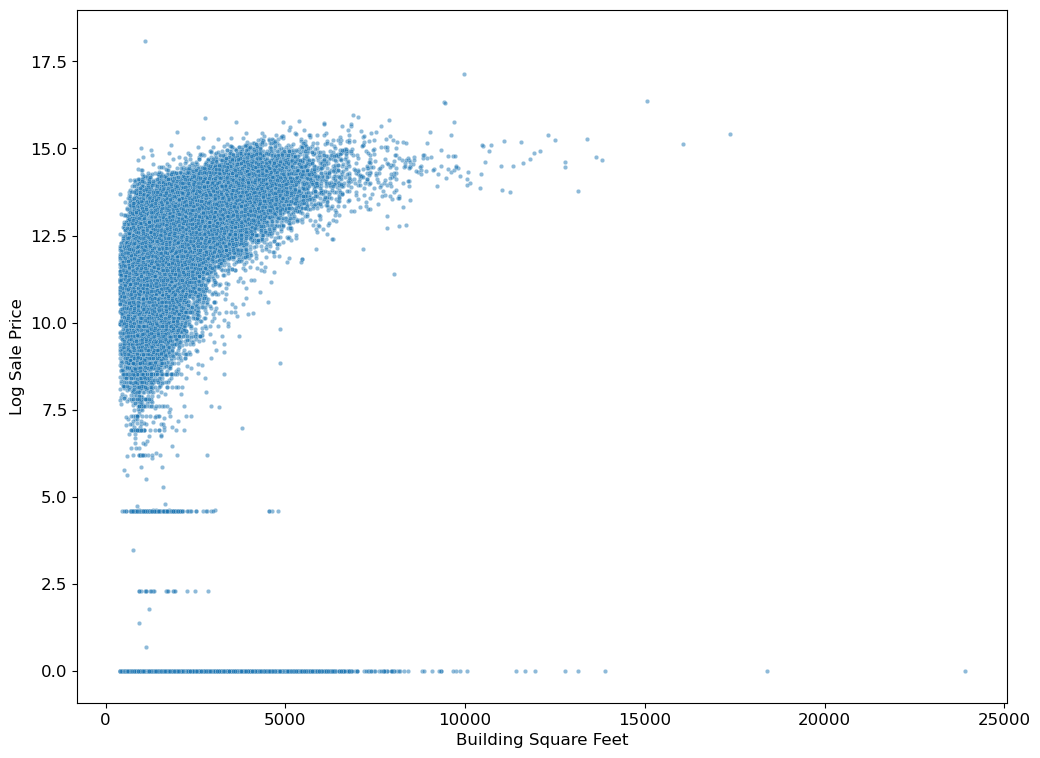

In [75]:
vsl = pd.read_csv("cook_county_train.csv")
vsl['Log Sale Price'] = np.log(vsl['Sale Price'])
sns.scatterplot(x = vsl['Building Square Feet'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

#### Distribution of `Building Square Feet`
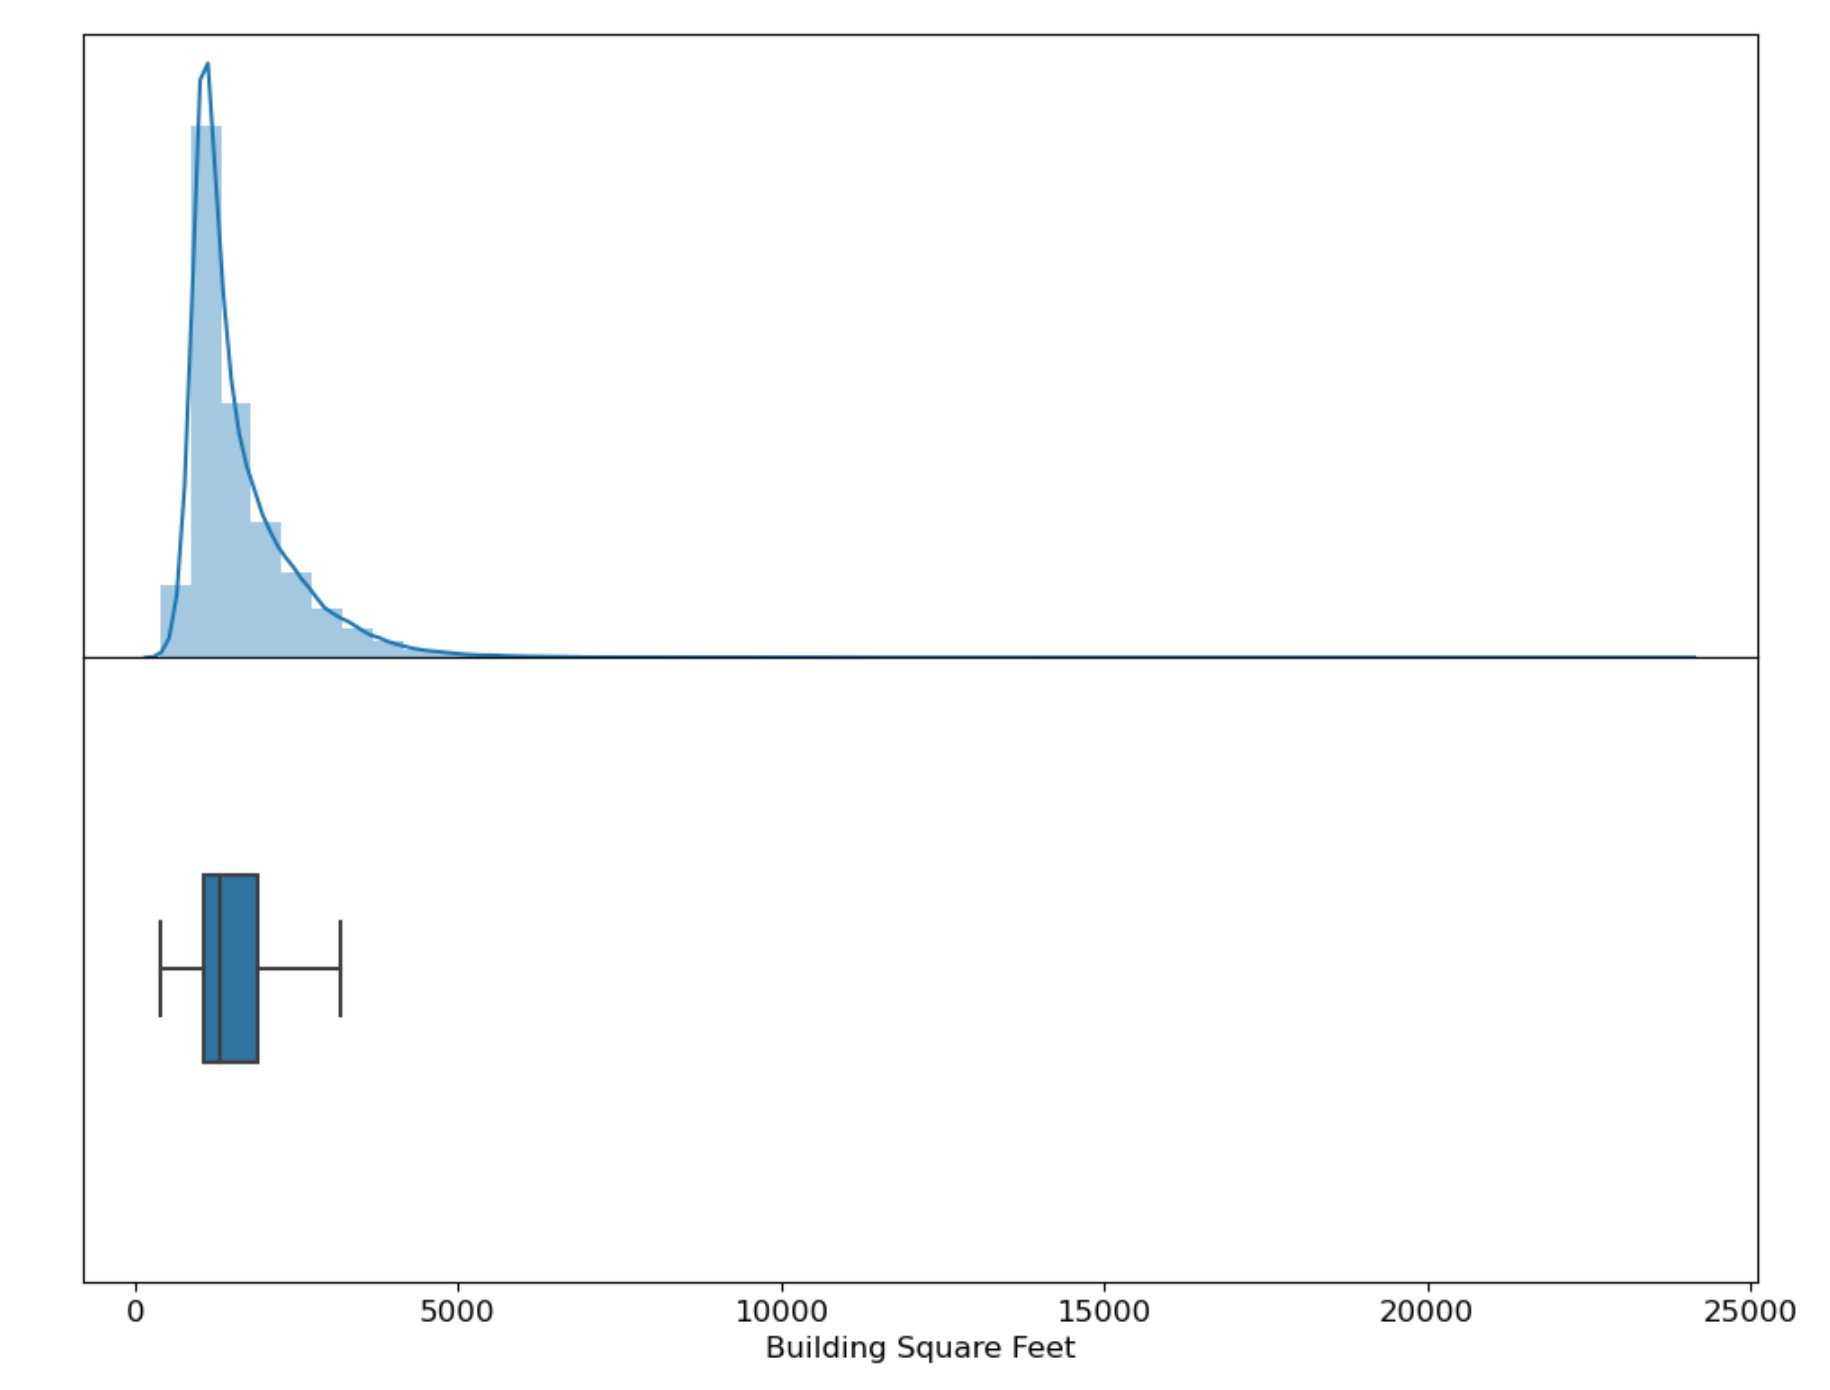

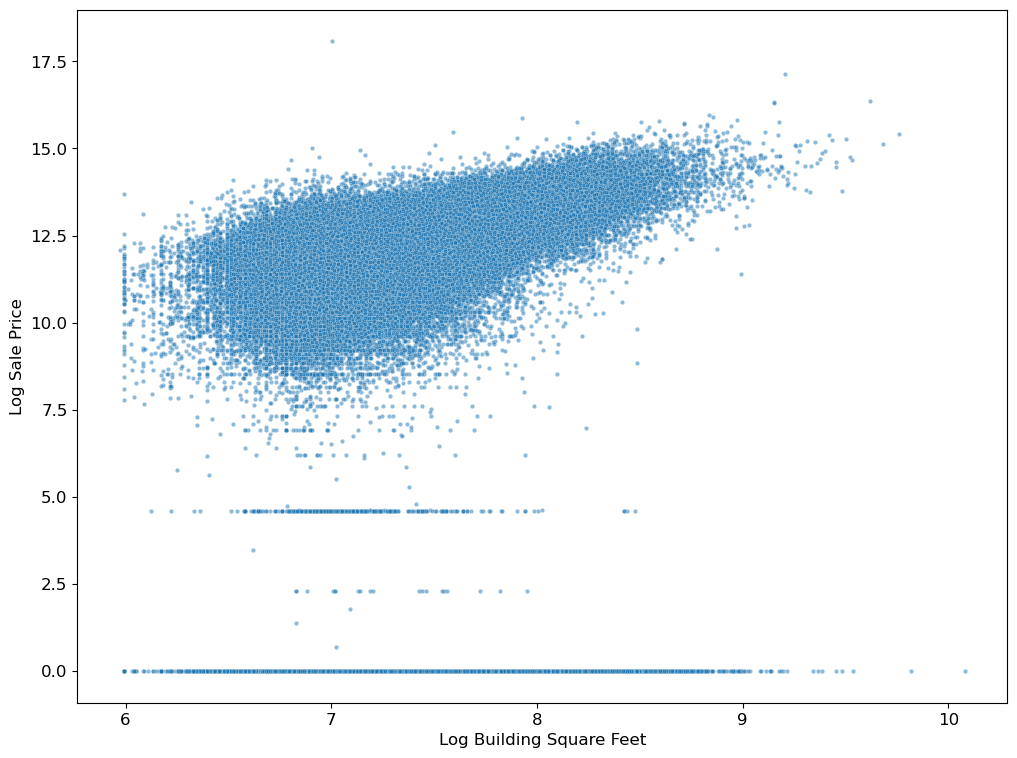

In [76]:
vsl['Log Building Square Feet'] = np.log(vsl['Building Square Feet'])
sns.scatterplot(x = vsl['Log Building Square Feet'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

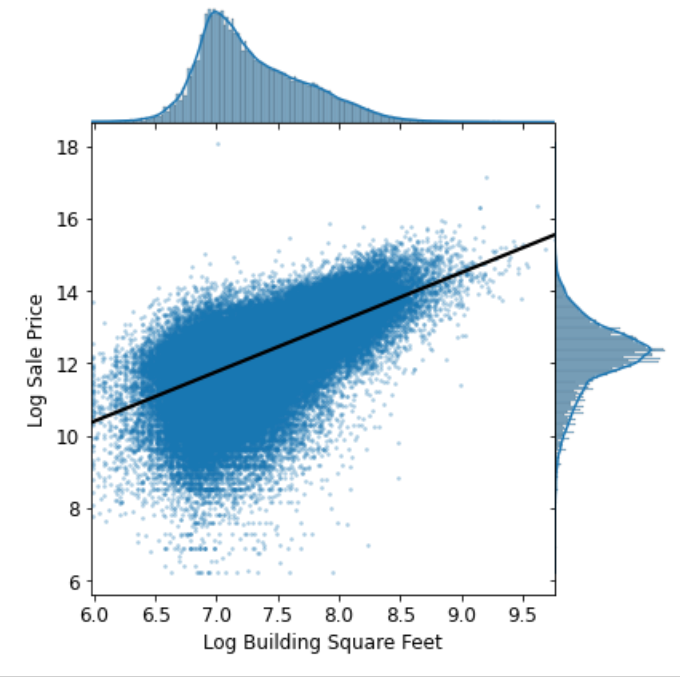

#### `Estimate (Building)`

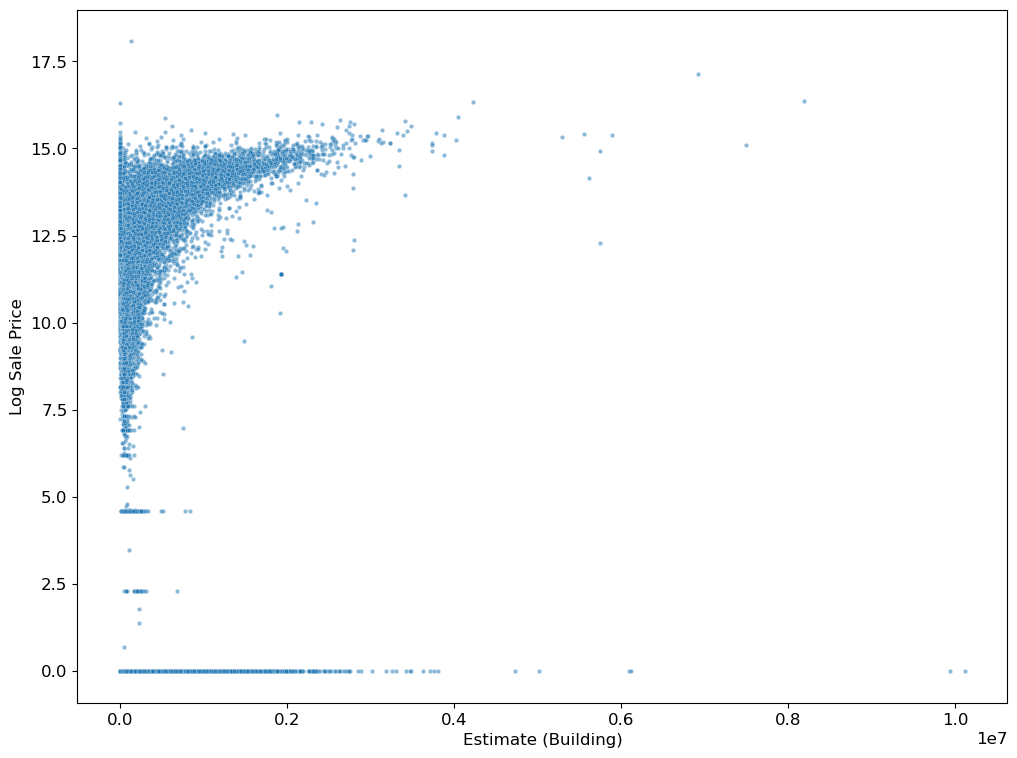

In [77]:
sns.scatterplot(x = vsl['Estimate (Building)'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

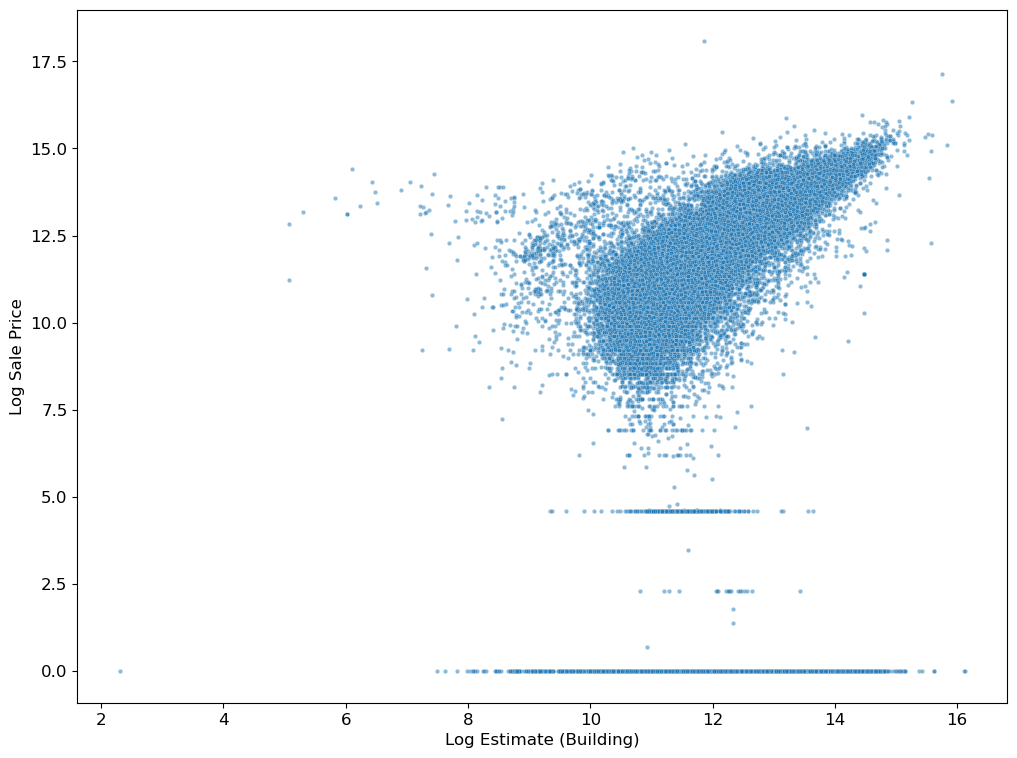

In [78]:
vsl['Log Estimate (Building)'] = np.log(vsl['Estimate (Building)'])
sns.scatterplot(x = vsl['Log Estimate (Building)'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

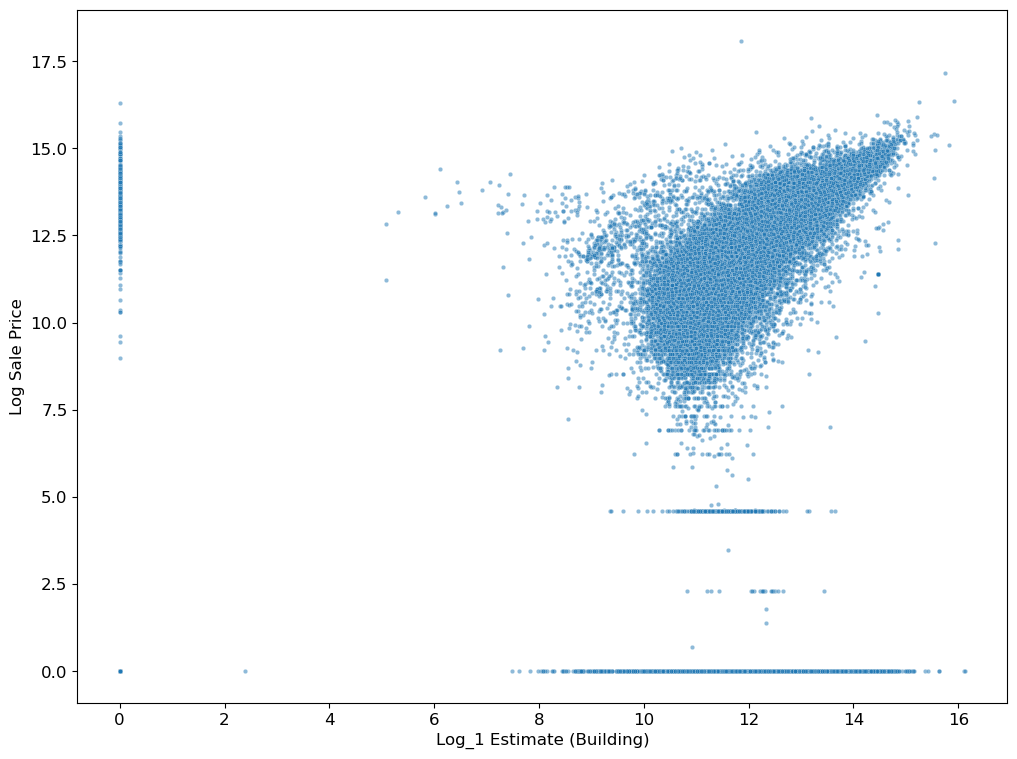

In [79]:
vsl['Log_1 Estimate (Building)'] = np.log(vsl['Estimate (Building)'] + 1)
sns.scatterplot(x = vsl['Log_1 Estimate (Building)'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

Since there is a positive relationship between 'Log Sale Price' and 'Log Building Square Feet' that as 'Log Sale Price'increases, 'Log Building Square Feet' increases, there is a positive correlation betweeen 'Log Sale Price' and 'Log Building Square Feet'. Although there are some outliers, 'Log Building Square Feet' and 'Log Sale Price' still perform a strong positive relationship. Therefore, 'Log Building Square Feet' makes a good candidate as one of the features for our model.

### Regular Expression
`Description` (Squared Bedrooms)

In [80]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

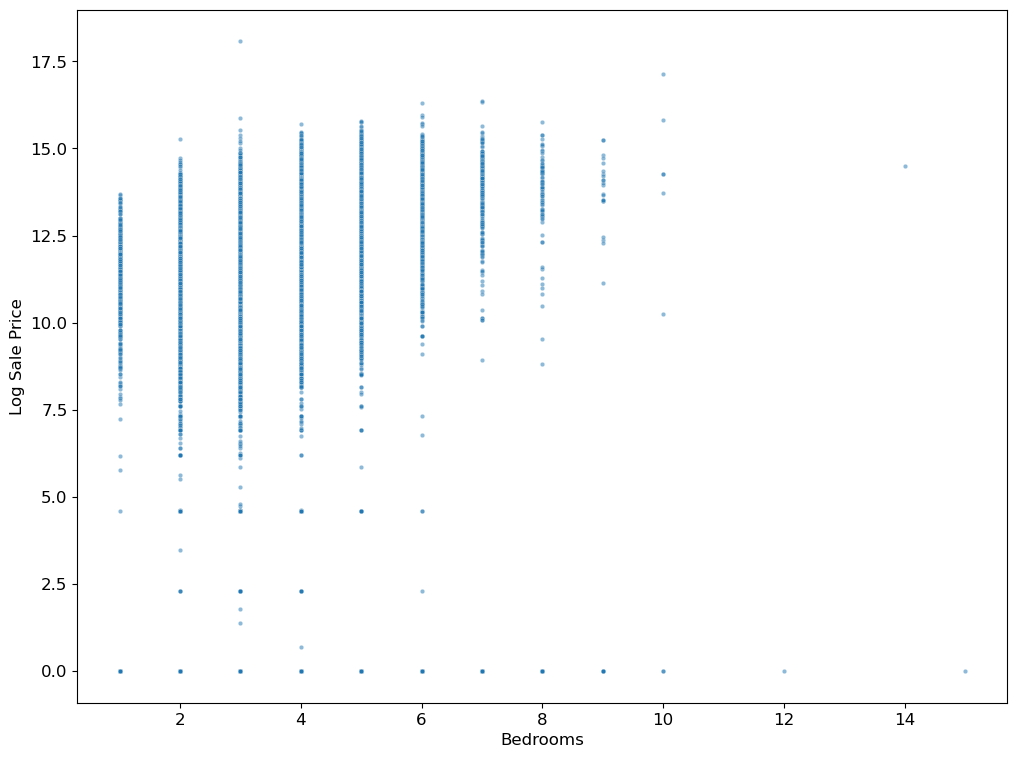

In [81]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    pattern = r'(\d+) of which are bedrooms'
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pattern).fillna(0).astype(int)
    return with_rooms

vsl = add_total_bedrooms(vsl)
sns.scatterplot(x = vsl['Bedrooms'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

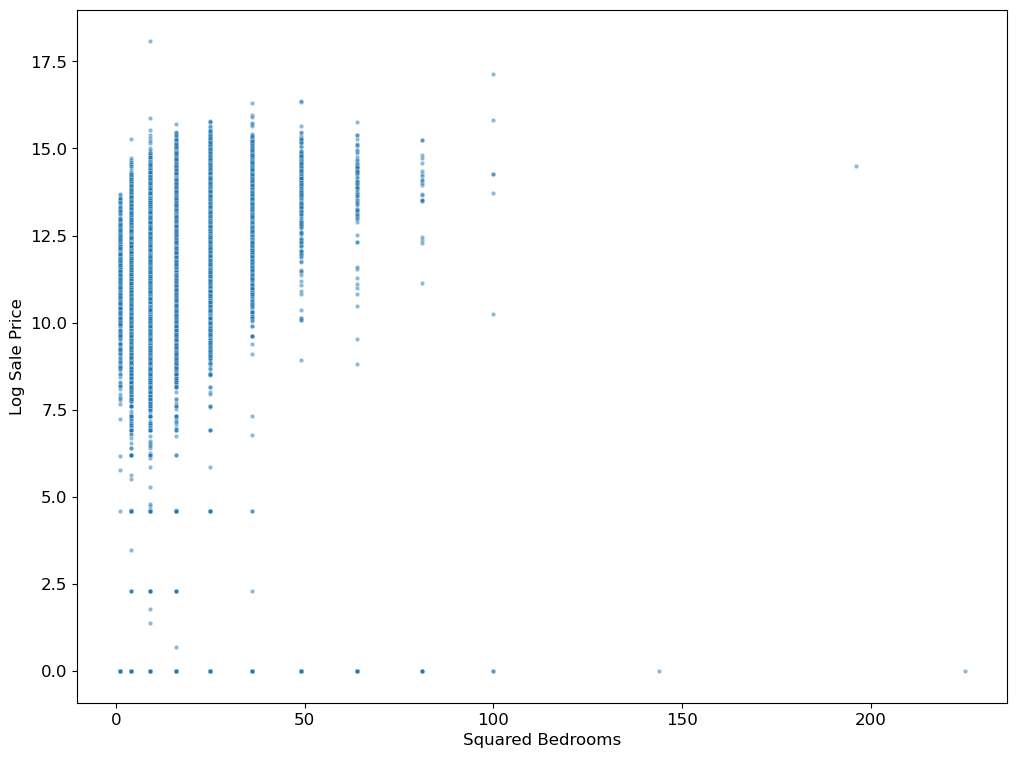

In [82]:
vsl['Squared Bedrooms'] = np.square(vsl['Bedrooms'])
sns.scatterplot(x = vsl['Squared Bedrooms'], y = vsl['Log Sale Price'], s = 10, alpha = 0.5);

### One Hot Encoding

`Roof Material` 

From "codebook.txt"
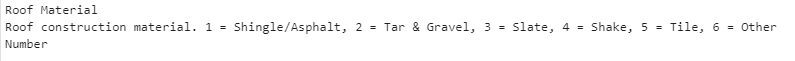

In [83]:
vsl['Roof Material'].unique()

array([1., 2., 6., 5., 4., 3.])

In [84]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    replacements = {
        'Roof Material': {
            1:'Shingle/Asphalt',
            2:'Tar&Gravel',
            3:'Slate',
            4:'Shake',
            5:'Tile',
            6:'Other', 
        }
    }
    
    data = data.replace(replacements)
    return data
    
training_data = substitute_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,Shingle/Asphalt,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


In [85]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Roof Material']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Roof Material']]).todense(),
                          columns = oh_enc.get_feature_names(),
                          index = data.index)
    return data.join(dummies)

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0


### Step 4: Improve and Evaluate Model Performance
- Try and Test
- The Bias-Variance Tradeoff

In [86]:
from sklearn.preprocessing import OneHotEncoder

def select_columns(data, *columns):
    return data.loc[:, columns]

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    return data.loc[(data[variable] > lower) & (data[variable] <= upper), :]

def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    replacements = {
        'Roof Material': {
            1:'Shingle/Asphalt',
            2:'Tar&Gravel',
            3:'Slate',
            4:'Shake',
            5:'Tile',
            6:'Other', 
        }
    }
    
    data = data.replace(replacements)
    return data

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Roof Material']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Roof Material']]).todense(),
                          columns = oh_enc.get_feature_names(),
                          index = data.index)
    return data.join(dummies)

def add_total_bedrooms(data):
    with_rooms = data.copy()
    pattern = r'(\d+) of which are bedrooms'
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pattern).fillna(0).astype(int)
    return with_rooms

def add_total_rooms(data):
    with_rooms = data.copy()
    rooms_regex = r'has a total of (\d+) rooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(int)
    with_rooms['Rooms'] = rooms
    return with_rooms

def log_transform_1(data,col):
    data['Log ' + col] = np.log(data[col]+1)
    return data

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def square(data, col):
    data['Squared ' + col] = np.square(data[col])
    return data

def root(data, col):
    data['Root ' + col] = np.sqrt(data[col])
    return data

def cube(data, col):
    data['Cubed ' + col] = np.power(data[col], 3)
    return data

In [87]:
def process_data_fm(data,is_test_set = False):
 
        
    # Add in Bedrooms    
    data = add_total_bedrooms(data)
    
    
    # Apply One-hot Encoding
    data = substitute_fireplaces(data)
    data = ohe_fireplaces(data)
    ohe_columns = data.filter(regex = '^x0_').columns.tolist()
    
#     data = substitute_roof_material(data)
#     data = ohe_roof_material(data)
#     ohe_columns = data.filter(regex = '^x0_').columns.tolist()
    

    
    if not is_test_set:
        
        # Remove Outliers
#         data = remove_outliers(data,
#                                variable = 'Sale Price',
#                                lower = np.percentile(data['Sale Price'],5),
#                                upper = np.percentile(data['Sale Price'],95))
        
        data = remove_outliers(data,
                               variable = 'Sale Price',
                               lower = 50000,
                               upper = 1000000)
        
        # Log Transform
        (data
             .pipe(log_transform, 'Sale Price')
             .pipe(log_transform, 'Building Square Feet')
             .pipe(log_transform_1, 'Estimate (Building)')
             .pipe(log_transform_1, 'Land Square Feet')
             .pipe(log_transform_1, 'Estimate (Land)')
             .pipe(log_transform_1, 'Lot Size')
        )
        
        # Square Transform
        (data
             .pipe(square, 'Lot Size')
             .pipe(square, 'Bedrooms')
        )
        
        # Root Square Transform
        (data
             .pipe(root, 'Garage 1 Area')
            .pipe(root, 'Garage 2 Area')
        )
        
        # Cube Transform
        (data
             .pipe(cube, 'Age')
        )
        
    
    
    
    # Transform Data, Select Features
    if not is_test_set:
        ohe_columns.append('Log Sale Price')
        data = select_columns(data,
                              'Log Building Square Feet',
                              'Log Land Square Feet',
                              'Log Estimate (Building)',
                              'Log Estimate (Land)',
#                               'Root Garage 1 Area',
#                               'Root Garage 2 Area',
                              'Log Lot Size',
#                               'Cubed Age',
                              'Bedrooms',
#                               'Road Proximity',
#                               'Repair Condition',
#                               'Apartments',
#                               'O\'Hare Noise',
#                               'Sale Year',
#                               'Log Estimate (Building)',

#                               'Attic Finish',
#                               'Basement Finish',
                              *ohe_columns
                             )
    
    # Return predictors and response variables separately
    if is_test_set:
        X = data.fillna(0)
        X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0) + 0.00001)
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        X = X.fillna(0)
        X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0) + 0.00001)
        return X, y

training_data = pd.read_csv('cook_county_train.csv')
processed_data = process_data_fm(training_data)
processed_data

(        Log Building Square Feet  Log Land Square Feet  \
 1                      -0.966557             -0.922566   
 3                      -0.560341             -0.667111   
 6                       0.409117              0.926662   
 7                       2.432797              0.750167   
 8                       0.851779             -1.269119   
 ...                          ...                   ...   
 204786                 -0.856822              0.779394   
 204788                  0.770073              1.653855   
 204789                 -1.188060             -0.908752   
 204790                 -0.499686              0.064632   
 204791                 -0.861598             -1.644985   
 
         Log Estimate (Building)  Log Estimate (Land)  Log Lot Size  Bedrooms  \
 1                      0.094943             0.293182     -0.922566 -0.260162   
 3                      0.172346            -0.641655     -0.667111 -0.260162   
 6                     -0.752715            -0.

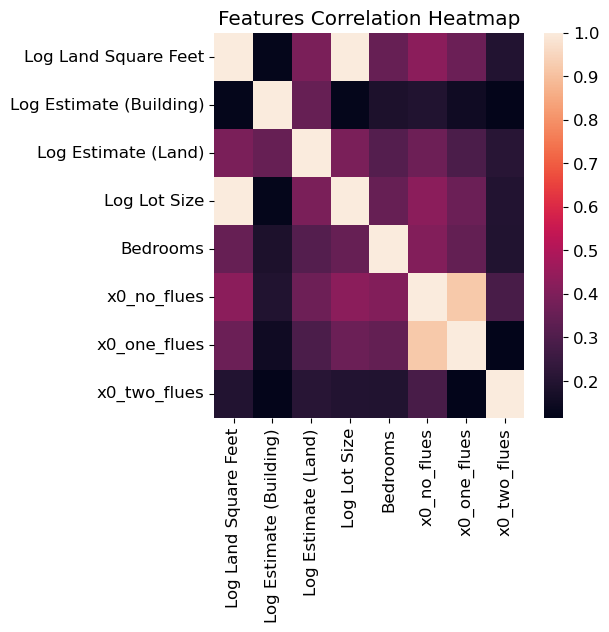

In [99]:
fig,ax = plt.subplots(figsize = (5,5))
sns.heatmap(abs(processed_data[0].corr()));
plt.title('Features Correlation Heatmap');

#### Training Error With `Log Building Square Feet`

In [89]:
from sklearn import linear_model as lm
run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, 200000, 'cook_county_train.csv', None, False, True)

Your RMSE loss is: 121972.20570026986


121972.20570026986

#### Training Error Without `Log Building Square Feet`

In [102]:
def process_data_fm(data,is_test_set = False):
 
        
    # Add in Bedrooms    
    data = add_total_bedrooms(data)
    
    
    # Apply One-hot Encoding
    data = substitute_fireplaces(data)
    data = ohe_fireplaces(data)
    ohe_columns = data.filter(regex = '^x0_').columns.tolist()
    

    if not is_test_set:
        
        data = remove_outliers(data,
                               variable = 'Sale Price',
                               lower = 50000,
                               upper = 1000000)
        
        # Log Transform
        (data
             .pipe(log_transform, 'Sale Price')
             .pipe(log_transform, 'Building Square Feet')
             .pipe(log_transform_1, 'Estimate (Building)')
             .pipe(log_transform_1, 'Land Square Feet')
             .pipe(log_transform_1, 'Estimate (Land)')
             .pipe(log_transform_1, 'Lot Size')
        )
        
    
    
    # Transform Data, Select Features
    if not is_test_set:
        ohe_columns.append('Log Sale Price')
        data = select_columns(data,
#                              'Log Building Square Feet',
                              'Log Land Square Feet',
                              'Log Estimate (Building)',
                              'Log Estimate (Land)',
                              'Log Lot Size',
                              'Bedrooms',
                              *ohe_columns
                             )
    
    # Return predictors and response variables separately
    if is_test_set:
        X = data.fillna(0)
        X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0) + 0.00001)
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        X = X.fillna(0)
        X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0) + 0.00001)
        return X, y

training_data = pd.read_csv('cook_county_train.csv')
processed_data = process_data_fm(training_data)
processed_data

(        Log Land Square Feet  Log Estimate (Building)  Log Estimate (Land)  \
 1                  -0.922566                 0.094943             0.293182   
 3                  -0.667111                 0.172346            -0.641655   
 6                   0.926662                -0.752715            -0.309362   
 7                   0.750167                 1.152891             1.474245   
 8                  -1.269119                 0.437489             0.065167   
 ...                      ...                      ...                  ...   
 204786              0.779394                 0.147920             0.133254   
 204788              1.653855                 0.211417             3.596675   
 204789             -0.908752                -0.568989            -0.828647   
 204790              0.064632                 0.322226             0.126722   
 204791             -1.644985                -0.264789            -1.245669   
 
         Log Lot Size  Bedrooms  x0_no_flues  x0_o

In [103]:
from sklearn import linear_model as lm
run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, 200000, 'cook_county_train.csv', None, False, True)

Your RMSE loss is: 133588.21697705204


133588.21697705204

Add `Log Building Square Feet`, Model is more complex, variance is increased, and overfitting (test error is incrased), but the bias(training error) is decreased. After weight these two, I chose to keep this feature

## Part 5: Back to the Real World

- Meaning of Error (actual - predicted)

Small error: a more accurate model results in fairer assessments.

Positive error: the property is being undervalued, corresponding to lower relative proporty taxes.

Negative error: the property is being overvalued, corresponding to higher relative proporty taxes.

- Accuracy & Fairness

Accuracy is a necessary, but not sufficient, condition of a fair system.

No control on how the model will be applied and how the property assessments in taxes will be worked.

Should consider the case on a broader scale.

- Error: the difference between the predicted value of a house and its actual sale price.

If the error is positive, meaning that the property has a higher predicted sales prices than its actual price, the property will be undervalued and correspond to lower relative property taxes, and vice versa.

If the error is small, meaning that the properties will  more likely to be valued at what they're worth, and relative to properties with similar characteristics. This will result to a fairer assessments

- However, accuracy is a necessary, but not sufficient, condition of a fair system. 

We have no control on how the model will be applied and how the property assessments in taxes will be worked. 

On the other hand, Only focusing on the individual cases is not enough, we should consider the case on a broader scale. For example, in Cook County, The houses in Black and Hispanic communities are overvalued and the houses in white communities are undervalued. 

Unfortunately, the works beyond the model and the historical trends and inequities could not be addressed by my model, but accurate prediction is still an important part to approach justice.



*(Evanston, IL - a suburb in Cook County- as an example of housing equity beyond just improving a property valuation model: Their city council members recently approved reparations for african american residents)


# Thank you!